In [56]:
import tensorflow as tf
from keras.layers import Dense, Conv2D, BatchNormalization, MaxPooling2D, Input, Flatten, Dropout
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.preprocessing import LabelBinarizer
import keras
from keras.models import Sequential, Model
from keras.callbacks import EarlyStopping
import random
from keras.applications import EfficientNetB0
from keras.layers import Input, Dense, Conv2D
from keras.models import Model

rs = 7284

np.random.seed(rs)
random.seed(rs)
tf.random.set_seed(rs)

# Load Data

Using subset I created with 50 species and 100 images each for the train data, and 5 each for the val and test data. Code for creating that dataset is in my 'brendon_test_file' codebook, but a couple notes on that:

- One of the birds that got selected was "Looney Birds" which are...not birds. I manually replaced that one with "HORNED GUAN"
- Toucan was mispelled as "Touchan" so I renamed that file. 

In [57]:
# Set file path for loading data
train_dir = './birds/train'
val_dir = "./birds/valid"
test_dir = "./birds/test"

In [58]:
# Instantiate the containers for holding image and label data
train_data = []
val_data = []
test_data = []

# Load train data
for i in os.listdir(train_dir):
    sub_directory = os.path.join(train_dir, i)
    for j in os.listdir(sub_directory):
        img = cv2.imread(os.path.join(sub_directory, j))
        train_data.append([img, i])

# Load validation data
for i in os.listdir(val_dir):
    sub_directory = os.path.join(val_dir, i)
    for j in os.listdir(sub_directory):
        img = cv2.imread(os.path.join(sub_directory, j))
        val_data.append([img, i])

#Load test data
for i in os.listdir(test_dir):
    sub_directory = os.path.join(test_dir, i)
    for j in os.listdir(sub_directory):
        img = cv2.imread(os.path.join(sub_directory, j))
        test_data.append([img, i])

print(len(train_data))
print(len(val_data))
print(len(test_data))

5000
250
250


In [59]:
# Check if all images are the same shape

count_t = 0
count_v = 0

for t in train_data:
    if t[0].shape != (224, 224, 3):
        count_t += 1
    
for v in val_data:
    if v[0].shape != (224, 224, 3):
        count_v += 1

print(f'There are {count_t} images of different shape in the train data.\nThere are {count_v} images of different shape in the validation data.')
    

There are 0 images of different shape in the train data.
There are 0 images of different shape in the validation data.


# Explore Data

Just looking at the first bird from each fo the 50 species we can already see that, even ignoring that they are different birds, there is a lot of variation in the images. Birds are in dfferent poses, some are just headshots while others are full body, and some are against solid backgrounds while others have landscape. Thsi could potentially be useful since this will give our model lots of diversity to learn from, but without looking through all 5000 photos, we can't know if some of the birds are more diverse than others and so our model will be able to learn them better. 

There are also a few instances where I suspect the model will struggle to differentiate, for instance the Great Xenops and Cedar Waxwing appear to be pretty similar, unless there are more distinctive photos in our training set, it may struggle to learn how to tell those apart.

In [60]:
# Create list of bird names
bird_names = set()

for x, y in val_data:
    bird_names.add(y)

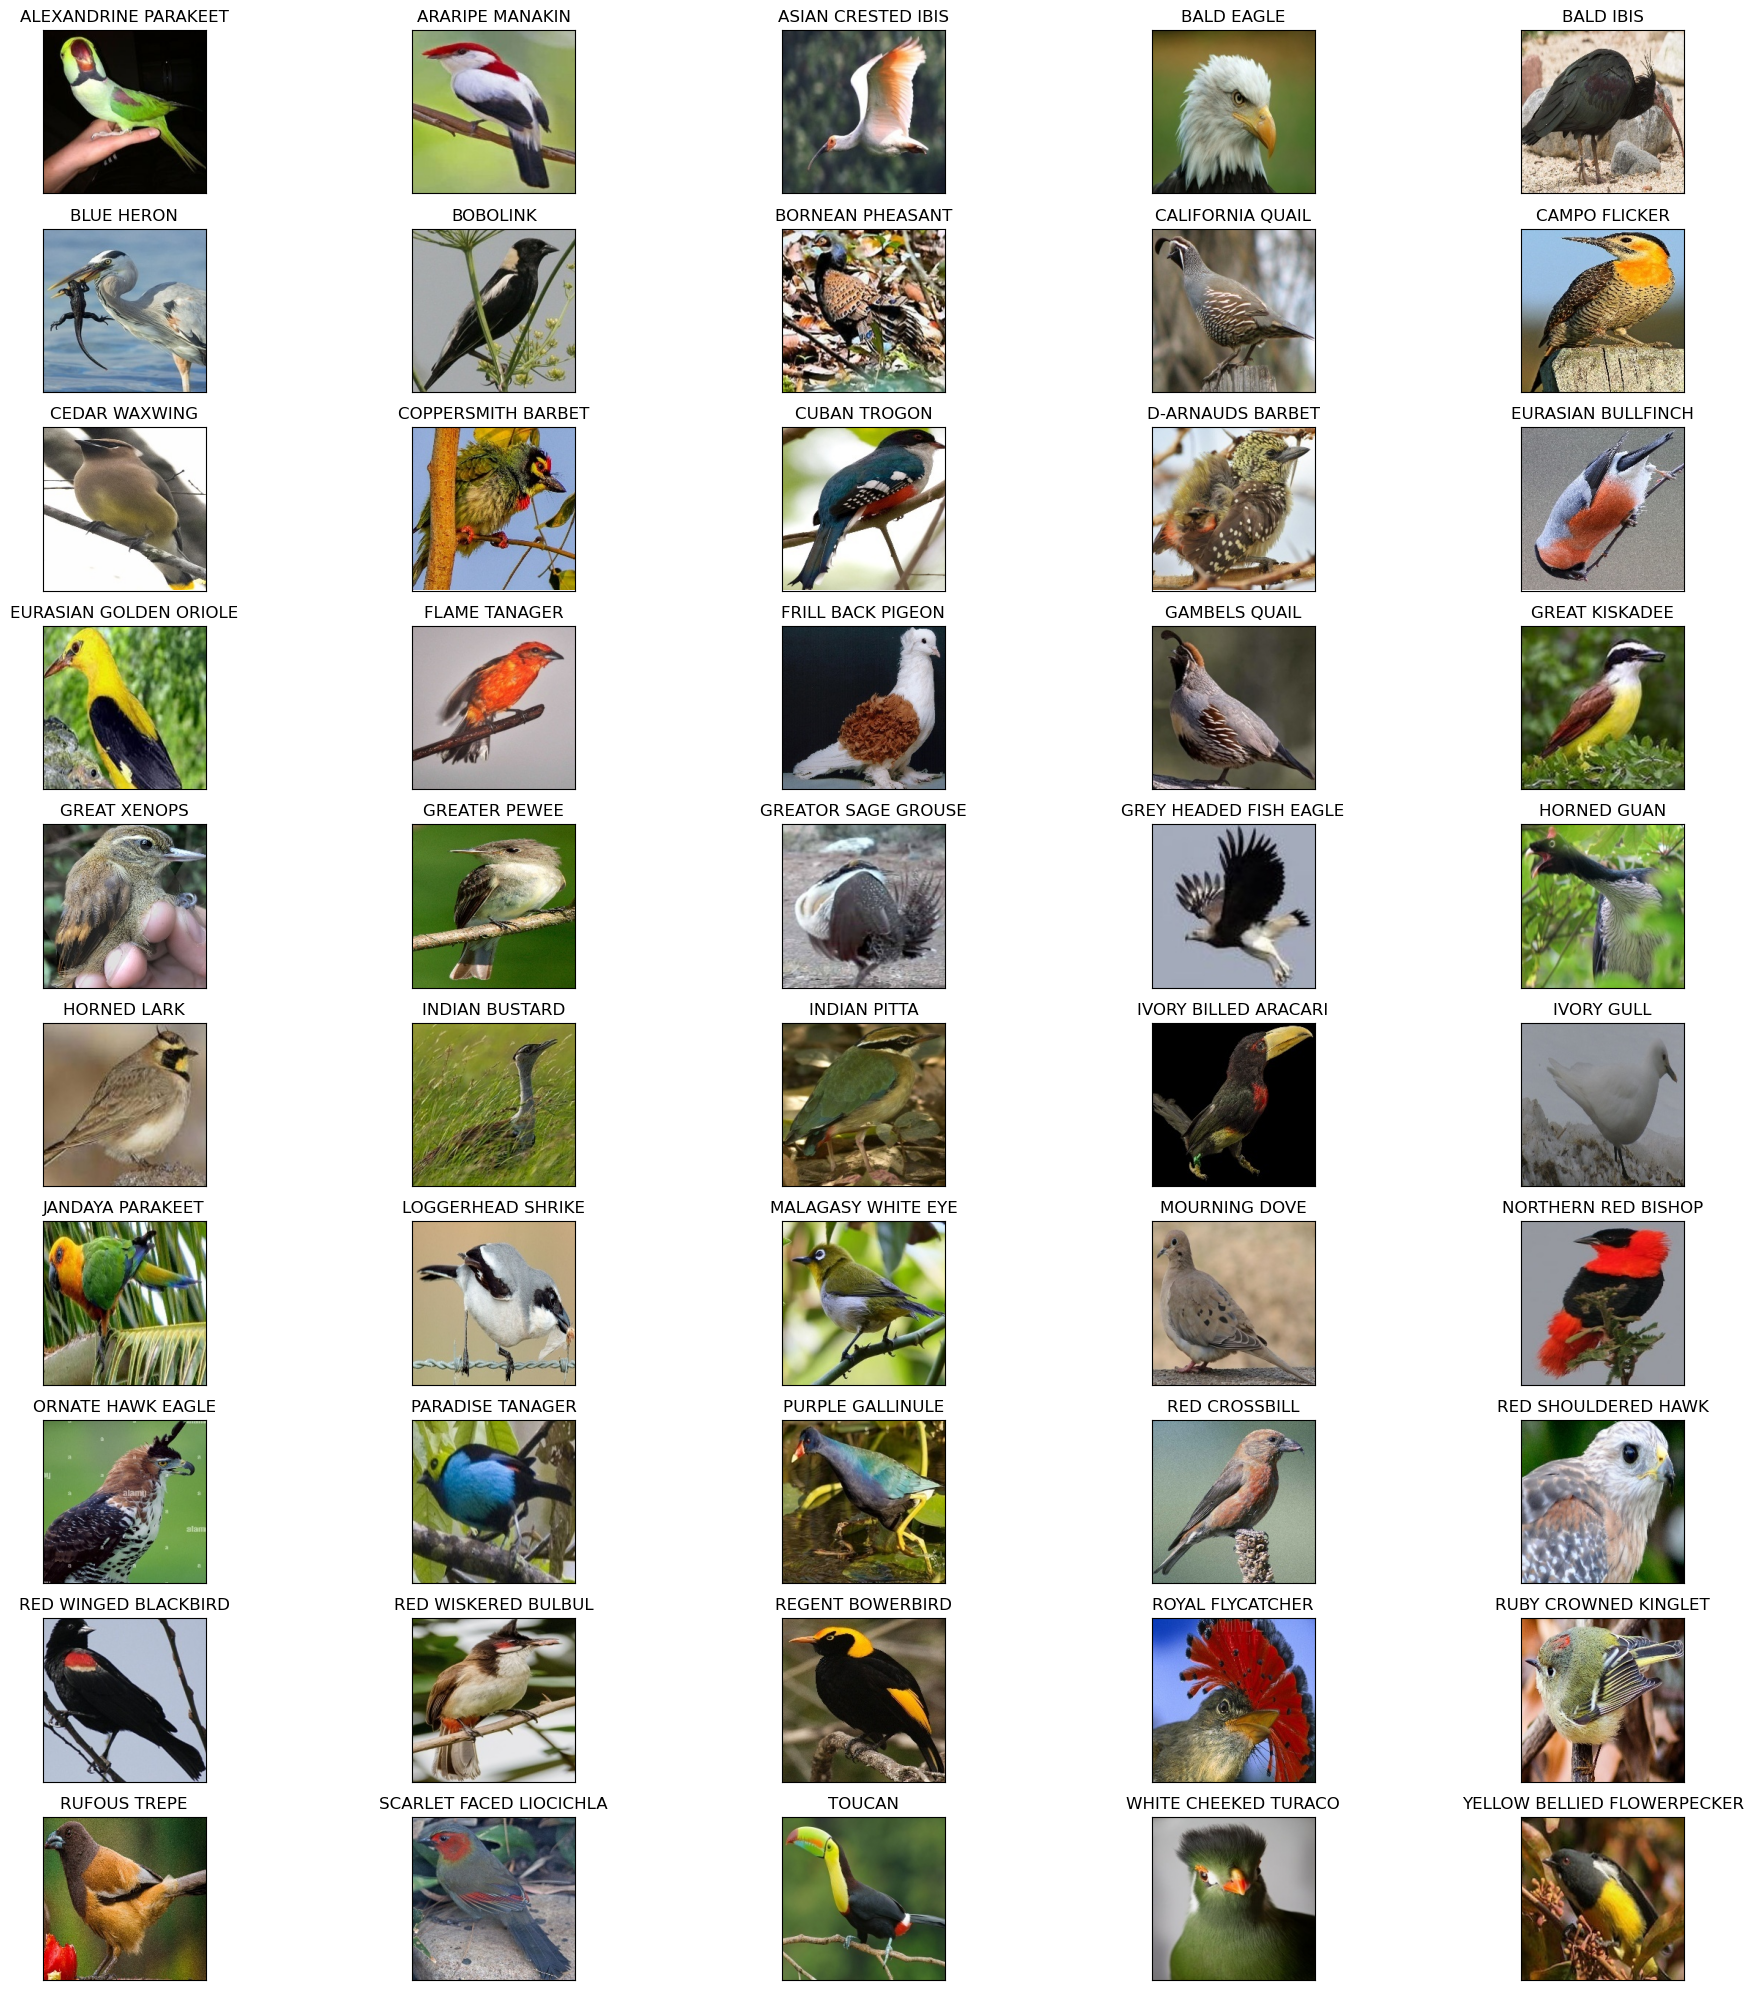

In [61]:
# Show an image for each bird
fig, axs = plt.subplots(10, 5, figsize=(20, 20))

axs = axs.ravel()

ax = 0
for idx in np.arange(0, 5000, 100):
    bird = train_data[idx][1]
    img = train_data[idx][0]
    axs[ax].xaxis.set_ticks([])
    axs[ax].yaxis.set_ticks([])
    axs[ax].set_title(bird)
    # Note that cv2 reads images in BGR, but plt.imshow is expecting RGB, cvtColor reverses the channels so the correct color is shown when plotted. 
    axs[ax].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax +=1

plt.tight_layout()
plt.show()

# PReapre Data for Training

In [62]:
# Shuffle data to randomize batches

np.random.seed(rs)
np.random.shuffle(train_data)
np.random.shuffle(val_data)

In [63]:
# Preprocess training data and validation data
lb = LabelBinarizer()

X_train = []
y_train = []
for x, y in train_data:
    X_train.append(x)
    y_train.append(y)

X_train = np.array(X_train)/255
y_train = np.array(y_train)

y_train_vect = lb.fit_transform(y_train)

X_val = []
y_val = []
for x, y in val_data:
    X_val.append(x)
    y_val.append(y)

X_val = np.array(X_val)/255
y_val = np.array(y_val)

y_val_vect = lb.fit_transform(y_val)

# Try an inital model

I am going to try a simple model to start to see what kind of accuracy we can get. A few thoughts up front:

- Because the images have been cropped fairly closely, I want to avoid losing features that may be important at the edge, so I will add padding to the model to keep from losing data
- Because small details may make a difference, particularly in birds that are simialr exepct for color variations or beak shape, I will use a smaller kernel to focus in on detailed images
- I'll test without any pooling at first to retain as many of the features as possible. 

In [76]:
# Set early stopping parameters
callback = EarlyStopping(monitor= 'val_loss', patience= 8, start_from_epoch= 10)

# BB Comments

I switched the code from the sequential method to this method because if we want to add any residual NN stuff we can't do that in Sequential (I think that was what he went through in class that adds "skip points" so the backward propogation can accomodate vanishing gradients). I ran both versions with the seed set and confirmed they produce identical results as long as all the hyperparameters match

I ran a couple tests that weren't completely insane run times, but they were long enough (7 minutes run time) that it made me nervous about how long it would take to run more complex models. So I paused to see if I could mess with google CoLAb instead. I'm also open to dropping our data down to a smaller amount if we need to. 


In [80]:
# Need to set all three seeds to get consistent results
np.random.seed(rs)
random.seed(rs)
tf.random.set_seed(rs)

inputs = Input(shape=(224, 224, 3))
cnn_1 = Conv2D(32, 3, activation= 'relu')(inputs)
flat = Flatten()(cnn_1)
predictions = Dense(50, activation='softmax')(flat)

model = Model(inputs=inputs, outputs=predictions)

model.compile(optimizer='adam', loss= 'categorical_crossentropy', metrics=['accuracy'])

history1 = model.fit(x = X_train, y= y_train_vect, batch_size=256, validation_data= (X_val, y_val_vect), verbose = 1, epochs = 50, callbacks= callback)

Epoch 1/50
20/20 [==============================] - 46s 2s/step - loss: 187.7234 - accuracy: 0.0326 - val_loss: 137.3724 - val_accuracy: 0.0480
Epoch 2/50
20/20 [==============================] - 46s 2s/step - loss: 44.4593 - accuracy: 0.1006 - val_loss: 3.8625 - val_accuracy: 0.1520
Epoch 3/50
 8/20 [===========>..................] - ETA: 27s - loss: 3.4634 - accuracy: 0.2402

KeyboardInterrupt: 